# Práctica de NLP & Searching

Ramón-Armand Laborda Moreu

## Objetivo

El siguiente documento se centra en aplicar un problema de NLP (Procesamiento del Lenguaje Natural) realizando un análisis de sentimiento a las opiniones publicadas en Amazon sobre una categoría de productos. 
Para tener un hilo conductor se dividirá en 4 apartados principalmente:

1. Descarga y exploración del corpus
2. Preprocesado de texto
3. Modelo de análisis de Sentimiento
4. Reporte de métricas y conclusiones

## 1. Descarga y exploración del corpus

McAuley Lab tiene disponible una colección de opiniones de Amazon convertidas ya en datasets crudos con los que podemos trabajar sin la necesidad de diseñar el webscrapping.

En la siguiente página web: <href> https://amazon-reviews-2023.github.io/ </href> se puede descargar un dataset correspondiente a las opiniones o reseñas y otro relativo al metadato del producto o las características comerciales.

De entre todas las categorías disponibles descargamos y descomprimimos en formato json la relacionada con: "Health and Personal Care"

In [4]:
import requests
import gzip
import shutil

url = 'https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_2023/raw/review_categories/Health_and_Personal_Care.jsonl.gz'
response = requests.get(url, stream=True)

with open('Health_and_Personal_Care.jsonl.gz', 'wb') as file:
        file.write(response.content)

Una vez descargado, descomprimimos el fichero .jsonl

In [5]:
with gzip.open('Health_and_Personal_Care.jsonl.gz', 'rb') as f_in:
    with open('Health_and_Personal_Care.jsonl', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

Para realizar un primer análisis exploratorio de la estructura del corpus, leemos el jsonl con pandas.

In [16]:
import pandas as pd

corpus_hcpc = pd.read_json('Health_and_Personal_Care.jsonl', lines = True)

In [17]:
corpus_hcpc.head(2)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True


Según la documentación original del dataset, y teniendo en mente el algoritmo que queremos ejecutar, hay campos que carecen de objeto de estudio. Eliminamos por tanto, "images", "asin", "parent_asin", "user_id", "timestamp", "helpful_vote" por el momento.

Nos quedamos con las variables:

- rating: (float) Rating of the product (from 1.0 to 5.0).
- title: (str) Title of the user review.
- text: (str) Text body of the user review.
- verified_purchase: (bool) User purchase verification.

In [18]:
corpus_hcpc.shape

(494121, 10)

In [19]:
corpus_hcpc.verified_purchase.value_counts()

verified_purchase
True     445072
False     49049
Name: count, dtype: int64

El primer paso es reducir el corpus utilizando exclusivamente opiniones de perfiles verificados. De esta forma se pretende disminuir el tamaño y mitigar opiniones generadas por bots o personas sin verificar.

In [20]:
corpus_hcpc = corpus_hcpc[corpus_hcpc.verified_purchase]
print(corpus_hcpc.shape)

(445072, 10)


Basándome en experiencias personales previas, el título de una reseña suele sintetizar lo que posteriormente se escribe en el texto (si es que se desarrolla un texto. Muchas veces por tiempo solo se indica el motivo de una opinión en el título) creo conveniente concatenar los campos de título y texto.

In [21]:
corpus_hcpc["title_text"] = corpus_hcpc["title"] + " " + corpus_hcpc["text"]

Filtramos los campos objeto de estudio para disponer de un corpus con el que hacer un análisis exploratorio de los datos.

In [23]:
corpus_hcpc = corpus_hcpc[['rating', 'title_text']]

In [36]:
print("El corpus tiene la siguiente estructura: ", corpus_hcpc.shape)
print("Con las siguientes columnas: ", ", ".join(corpus_hcpc.columns))

El corpus tiene la siguiente estructura:  (445072, 2)
Con las siguientes columnas:  rating, title_text


### Cardinalidad del vocabulario

Usamos la libreria sklearn, tokenizamos y observamos cuales son las palabras únicas excluyendo stopwords.

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus_hcpc['title_text'])

print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))

Cardinalidad del vocabulario:  85977


Parece que hay muchas palabras distintas. Es posible que se deba a los productos y la variedad de vocabulario. En cualquier caso, quiero observar cual sería la cardinalidad lematizando para reducirla un poco.

In [64]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

lemmatizer = WordNetLemmatizer()

def lemmatize_text_nltk(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

lemmatized_corpus = [lemmatize_text_nltk(doc) for doc in corpus_hcpc['title_text']]

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(lemmatized_corpus)

print("Cardinalidad del vocabulario: ", len(vectorizer.get_feature_names_out()))

Cardinalidad del vocabulario:  84646


Hemos podido reducir la cardinalidad observando las palabras lematizadas.

### Distribución de opiniones por número de estrellas

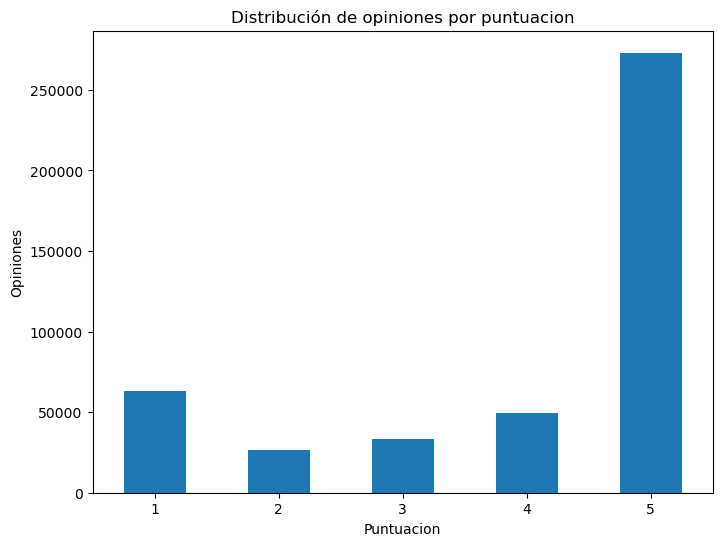

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
corpus_hcpc['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de opiniones por puntuacion')
plt.xlabel('Puntuacion')
plt.ylabel('Opiniones')
plt.xticks(rotation=0)
plt.show()